In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from scikeras.wrappers import KerasRegressor

In [15]:
df = pd.read_csv('processedcsv/combinedstats.csv')
df.dropna(inplace=True)
X = df.drop(['player_id', 'firstName', 'lastName', 'season', 'salary', 'avgTimeOnIce', 'avgPowerPlayTimeOnIce', 'avgShortHandedTimeOnIce', 'birthDate'], axis=1)
y = df.filter(['salary'])

In [12]:
onehot = OneHotEncoder()
X_pos = onehot.fit_transform(X[['primaryPosition']])
X_hand = onehot.fit_transform(X[['shootsCatches']])
df1 = pd.DataFrame.sparse.from_spmatrix(X_pos)
df2 = pd.DataFrame.sparse.from_spmatrix(X_hand)
df1.rename(columns={0: 'isC', 1: 'isD', 2: 'isLW', 3: 'isRW'}, inplace=True)
df2.rename(columns={0: 'shootsL', 1: 'shootsR'}, inplace=True)
df3 = pd.concat([df1, df2], axis=1)
X_new = pd.concat([df3.reset_index(), X.drop(['primaryPosition', 'shootsCatches'], axis=1).reset_index()], axis=1)
X_normalized=(X_new-X_new.min())/(X_new.max()-X_new.min())

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.30, random_state=5)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=5)

In [28]:
clf = Lasso()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
results = y_test.copy()
results['pred'] = y_pred.tolist()

C:\Users\Jacky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:754: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Jacky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.847e+14, tolerance: 1.691e+12
  model = cd_fast.enet_coordinate_descent(
C:\Users\Jacky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:754: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense nu

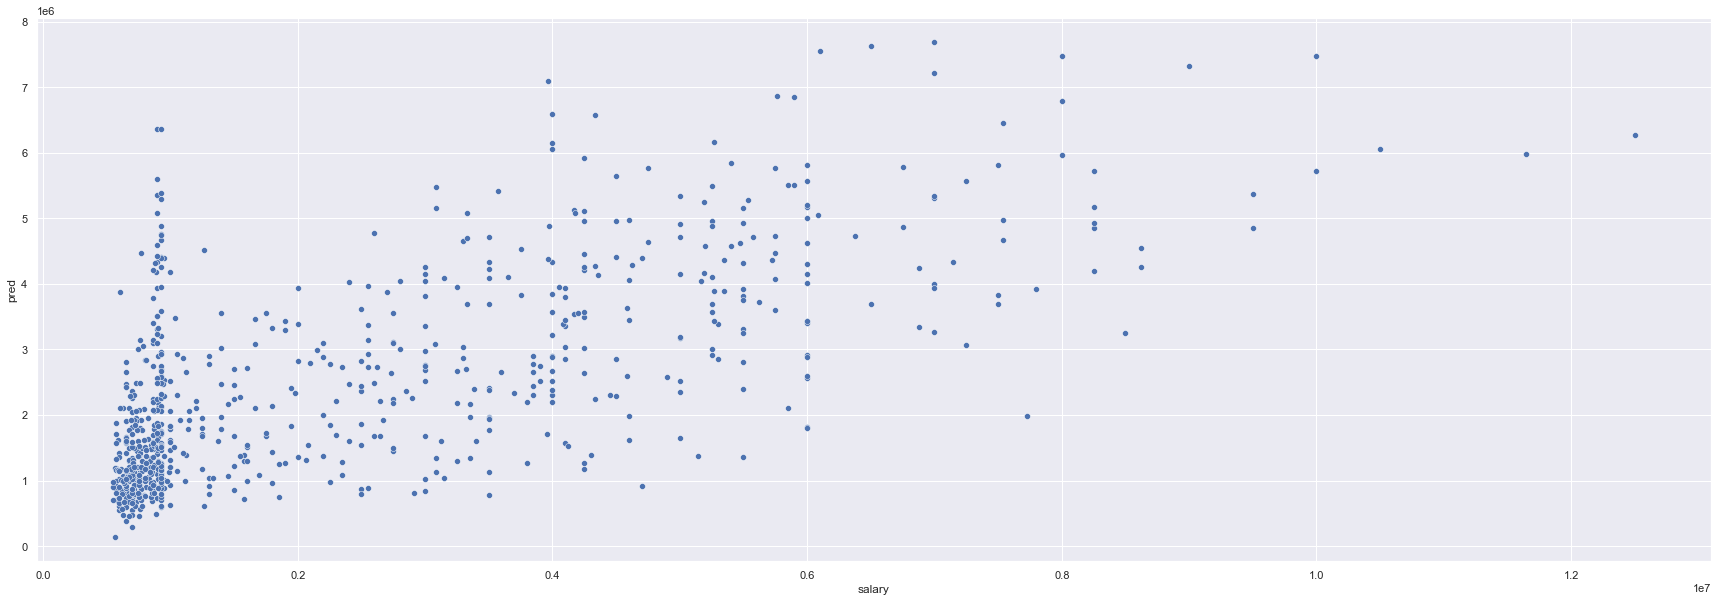

In [32]:
sns.set(rc = {'figure.figsize':(30,10)})
sns.scatterplot(x='salary', y='pred', data=results);

In [ ]:
selector = RFE(clf, n_features_to_select=10, step=1)
selector = selector.fit(X_train, y_train)

In [39]:
selector.get_support()

array([False, False, False, False, False, False, False, False,  True,
       False, False, False,  True, False,  True, False, False,  True,
        True,  True,  True, False, False, False, False, False,  True,
       False, False, False,  True, False, False, False,  True])

In [38]:
print(X_train.shape)
list(X_train.columns)

(3634, 35)


['index',
 'isC',
 'isD',
 'isLW',
 'isRW',
 'shootsL',
 'shootsR',
 'index',
 'gamesPlayed',
 'goals',
 'assists',
 'points',
 'pointsPerGame',
 'plusMinus',
 'shots',
 'shootingPercentage',
 'penaltyMinutes',
 'timeOnIce',
 'faceOffWins',
 'faceOffLosses',
 'faceOffTaken',
 'faceOffPercentage',
 'hits',
 'blocks',
 'takeaways',
 'giveaways',
 'turnoverDifferential',
 'powerPlayGoals',
 'powerPlayAssists',
 'powerPlayPoints',
 'powerPlayTimeOnIce',
 'shortHandedGoals',
 'shortHandedAssists',
 'shortHandedPoints',
 'shortHandedTimeOnIce']

In [40]:
def get_model():
    model = Sequential()
    model.add(Dense(35, input_dim= 35, activation='relu'))
    model.add(Dense(22, kernel_initializer='normal'))
    model.add(Dense(11, kernel_initializer='normal'))
    model.add(Dense(6, kernel_initializer='normal'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
    return model

model = get_model()
model.fit(X_train, y_train, epochs = 200, batch_size = 5)
y_pred = model.predict(X_val)

Epoch 1/200
727/727 [==============================] - 1s 971us/step - loss: 8430885535744.0000 - mean_absolute_error: 2057280.2500
Epoch 2/200
727/727 [==============================] - 1s 722us/step - loss: 3141745246208.0000 - mean_absolute_error: 1458612.6250
Epoch 3/200
727/727 [==============================] - 1s 753us/step - loss: 2969852968960.0000 - mean_absolute_error: 1412011.0000
Epoch 4/200
727/727 [==============================] - 1s 716us/step - loss: 2843331002368.0000 - mean_absolute_error: 1357471.5000
Epoch 5/200
727/727 [==============================] - 1s 715us/step - loss: 2746796212224.0000 - mean_absolute_error: 1309763.1250
Epoch 6/200
727/727 [==============================] - 1s 767us/step - loss: 2671655256064.0000 - mean_absolute_error: 1264155.2500
Epoch 7/200
727/727 [==============================] - 1s 717us/step - loss: 2616233295872.0000 - mean_absolute_error: 1231318.8750
Epoch 8/200
727/727 [==============================] - 1s 713us/step - loss: